<a href="https://colab.research.google.com/github/ludutram/LucianaDutra/blob/master/C%C3%B3pia_de__Atividade_Aula_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 14.9 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import collections
from plotly.offline import iplot
import plotly.express as px
import numpy as np
from tqdm import tqdm

In [ ]:
from gymnasium import spaces

class CustomEnvironment(gym.Env):
    def __init__(self):

        self.start_state = [0, 0]
        self.current_state = self.start_state
        self.timestep = 0
        self.reward_function = np.array( [ 
            [0.0, 0.0,  0.0,  0.0,  0.0, -1.0, 10.0],
            [0.0, 0.0,  0.0,  0.0,  0.0, -1.0,  0.0],
            [0.0, 0.0,  0.0, -1.0,  0.0,  0.0,  0.0],
            [0.0, 0.0,  0.0, -1.0,  0.0,  0.0,  0.0],
             ] )
        self.walkable_terrain = np.array( [ 
            [True, True, True, True, True, True, True],
            [True, True, True, True, True, True, True],
            [True, True, True, True, True, True, True],
            [True, True, True, True, True, True, True],

             ] )
        self.terminal_states = [[0, 6]]

        self.action_space = spaces.Discrete(4)
        #shape[0] é o indice de colunas e shape [1] o indice de linhas
        #observation_spaces = 4 * 7 = 28
        self.observation_space = spaces.Discrete(self.reward_function.shape[0]*self.reward_function.shape[1])
        self.action_map = ["UP", "DOWN", "LEFT", "RIGHT"]
        
    def _transition_function(self, current_state, action):
        
        if action == "UP":
            desired_state = [current_state[0]-1, current_state[1]]  #ao ir para cima "UP" diminui o índice da linha e permane o índice da coluna.
        elif action == "DOWN":
            desired_state = [current_state[0]+1, current_state[1]]  #ao ir para baixo "DOWN" aumenta o índice da linha e permanece o índice da coluna.
        elif action == "LEFT":
            desired_state = [current_state[0], current_state[1]-1] #ao ir para esquerda "LEFT" permanece o índice da linha e diminui o índice da coluna.
        elif action == "RIGHT":
            desired_state = [current_state[0], current_state[1]+1] #ao ir para direita "RIGHT" permanece o índice da linha e aumenta o índice da coluna.
        else:
            raise Exception("Action | {} | outside the action space".format(action))

        # Check if the desired state is inside the grid. Verifica que o estado desejado está dentro da grade.
        if ( desired_state[0] < self.walkable_terrain.shape[0] and #se o índice da linha do estado desejado for menor que índice da linha do terreno permitido para caminhar = TRUE
            desired_state[1] < self.walkable_terrain.shape[1] and #se o índice da coluna do estado desejado for menor que índice da linha do terreno permitido para caminhar = TRUE
            desired_state[0] >= 0 and
            desired_state[1] >= 0  ):

            # Should the desired state be inside the grid, check if it's walkable. 
            # Caso o estado desejado esteja dentro da grade, verifique se é passível de caminhada
            if self.walkable_terrain[desired_state[0]][desired_state[1]]:
                current_state = desired_state

        # If neither condition is met then the state remains unchanged i.e. he bumped into a wall
        #Se nenhuma condição for atendida, o estado permanece inalterado, ou seja, ele bateu em uma parede
        return current_state

    
    def step(self, action):
        action = self.action_map[action]
        self.current_state = self._transition_function(self.current_state, action)
        obs = self.current_state
        reward = self.reward_function[self.current_state[0]][self.current_state[1]] #recompensa = função de recompensa (estado_atual[linha],estado_atual[coluna])
        done = (self.current_state in self.terminal_states)
        info = {}
        self.timestep += 1  #acumula os passos
        trunc = False
        if self.timestep >= 100:
            trunc = True
        
        return self._state_to_obs(obs), reward, done, trunc, info

    def reset(self, custom_start=None):
        # !!! O custom_start não é usual e está presente aqui somente para realizar a 
        # avaliação de políticas exatamente como descrita na teoria

        if custom_start:
            self.current_state = custom_start
        else:
            self.current_state = self.start_state
        self.timestep = 0
        obs = self.current_state

        return self._state_to_obs(obs), {}

    def _state_to_obs(self, s):
        return s[0]*self.reward_function.shape[1] + s[1]  #índice da linha do estado * índice da coluna da função de recompensa + índice da coluna do Estado





gym.envs.register(
     id='CustomMap',
     entry_point="__main__:CustomEnvironment",
)

# DynaQ vs Q-Learning

Implementar Dyna e comparar com Q-learning em timesteps para atingir média X de recompensa

In [ ]:
class QAgent:
    def __init__(self, epsilon, alpha, action_space):
        # função Q inicializada com dicionário onde as chaves são tuplas (estado, ação)
        self.Q = collections.defaultdict(lambda: 0.0) 
        self.epsilon = epsilon
        self.alpha = alpha
        self.action_space = action_space

    # Dado um estado, esta função retorna a melhor ação e o seu valor
    # Caso duas ações possuam o mesmo valor, uma aleatória (entre essas) é escolhida
    def best_value_and_action(self, state):
        a_values = []
        for action in range(self.action_space.n):
            a_values.append(self.Q[(state, action)])
        best_value = max(a_values)
        indices = [idx for idx, val in enumerate(a_values) if val == best_value] # separa indices com maior valor
        best_action = np.random.choice(indices) # escolhe aleatoriamente entre os índices de melhor valor
        return best_value, best_action

    # Função para política epsilon-greedy, retorna a ação escolhida
    def e_greedy(self, state):
        rand = np.random.random()
        if rand < self.epsilon:
            action = self.action_space.sample() # ação aleatória
        else:
            _, action = self.best_value_and_action(state)
        return action
    
    def learn(self, state, action, reward, next_state):

        best_v, _ = self.best_value_and_action(next_state)
        self.Q[(state, action)] = self.Q[(state, action)] + self.alpha * (reward + GAMMA * best_v - self.Q[(state, action)]) 


In [ ]:
def run_q_learning():
    np.random.seed(123)
    test_env = gym.make(ENV_NAME)

    env = gym.make(ENV_NAME)

    agent = QAgent(EPSILON, ALPHA, env.action_space)

    metrics = collections.defaultdict(list)

    iter_no = 0
    returns = collections.deque(maxlen=SMOOTHING)
    ep_lens = collections.deque(maxlen=SMOOTHING)
    pbar = tqdm(total=MAX_ITERATIONS, position=0, leave=True)
    state, _ = env.reset()
    while iter_no < MAX_ITERATIONS:
        iter_no += 1
        action = agent.e_greedy(state)
        next_s, r, is_term, is_trunc, _ = env.step(action)
        agent.learn(state, action, r, next_s)

        is_done = is_term or is_trunc
        if is_done:
            state, _ = env.reset() 
        else: 
            state = next_s

        sum_returns = 0.0
        sum_steps = 0.0
        for _ in range(TEST_EPISODES):

            # Para teste, executaremos vários episódios escolhendo apenas a ação de melhor valor de acordo com Q
            ep_rewards = []
            _state, _ = test_env.reset()
            n_steps = 0
            while True:
                _, _action = agent.best_value_and_action(_state)
                _new_state, _r, _is_term, _is_trunc, _ = test_env.step(_action)
                _is_done = _is_term or _is_trunc
                ep_rewards.append(_r) 
                n_steps+=1  # contando o tamanho do episódio
                if _is_done:
                    break
                _state = _new_state
              
  
            last_r = 0.0
            for rew in reversed(ep_rewards):
                last_r = rew + GAMMA*last_r
                
            sum_returns += last_r
            sum_steps += n_steps
            
        mean_return = sum_returns/TEST_EPISODES
        mean_steps = sum_steps/TEST_EPISODES
        
        returns.append(mean_return)
        ep_lens.append(mean_steps)
        
        metrics["test_return"].append(np.array(returns).mean())
        metrics["episode_len"].append(np.array(ep_lens).mean())
        pbar.update(1)
        pbar.set_description("Iter %i | Reward %.4f | Ep len %.2f |" % (iter_no, np.array(returns).mean(), np.array(ep_lens).mean()))


    return agent, metrics["test_return"], metrics["episode_len"]

In [ ]:
ENV_NAME = "CustomMap"
GAMMA = 0.95
ALPHA = 0.3 # taxa de aprendizado
EPSILON = 0.1
TEST_EPISODES = 5 # episódios executados para teste
MAX_ITERATIONS = 1500
SMOOTHING = 50

In [ ]:
q_metrics = collections.defaultdict(list)

for _ in range(5):

    agent, metrics_reward, metrics_len = run_q_learning() #esta função não deve demorar mais que ~3min

    q_metrics["test_return"].append(np.array(metrics_reward))
    q_metrics["episode_len"].append(np.array(metrics_len))

q_metrics["test_return"] = np.array(q_metrics["test_return"]).mean(axis=0)
q_metrics["episode_len"] = np.array(q_metrics["episode_len"]).mean(axis=0)

  0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:190: UserWarning:

WARN: Future gymnasium versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.

/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:203: UserWarning:

WARN: Future gymnasium versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.

Iter 1500 | Reward 1.6365 | Ep len 57.44 |: 100%|██████████| 1500/1500 [00:37<00:00, 40.38it/s]
Iter 1500 | Reward 5.4745 | Ep len 8.00 |: 100%|██████████| 1500/1500 [00:14<00:00, 101.81it/s]
Iter 1500 | Reward 6.3025 | Ep len 10.00 |: 100%|██████████| 1500/1500 [00:22<00:00, 67.20it/s] 
Iter 1500 | Reward 6.3025 | Ep len 10.00 |: 100%|██████████| 1500/1500 [00:15<00:00, 95.70it/s] 
Iter 1500 | Reward 0.1921 | Ep len 91.56 |: 100

## Exercício 01

Altere as células abaixo para implementar o algoritmo Dyna-Q. 

Em seguida, execute as células seguintes para diferentes valores de N

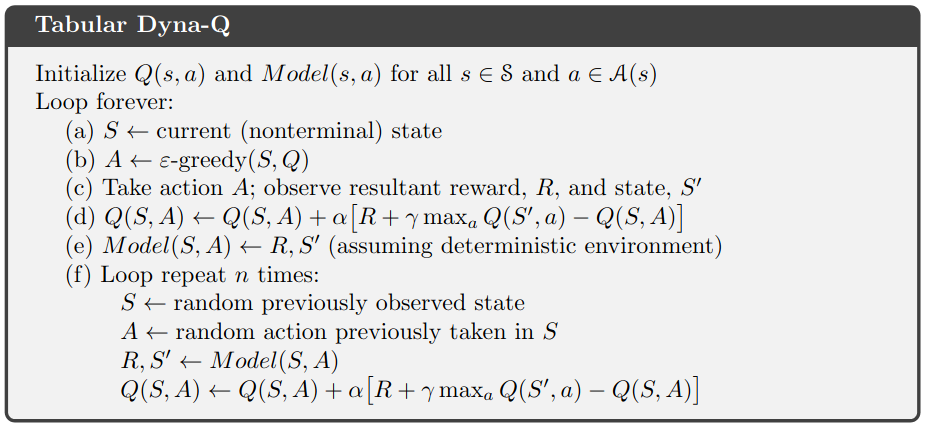

In [ ]:
class DynaQAgent:
    def __init__(self, epsilon, alpha, action_space):
        # função Q inicializada com dicionário onde as chaves são tuplas (estado, ação)
        self.Q = collections.defaultdict(lambda: 0.0) 
        self.epsilon = epsilon
        self.alpha = alpha
        self.action_space = action_space
        ####### adicionando um dicionário para o modelo ############
        self.Model = {}

    # Dado um estado, esta função retorna a melhor ação e o seu valor
    # Caso duas ações possuam o mesmo valor, uma aleatória (entre essas) é escolhida
    def best_value_and_action(self, state):
        a_values = []
        for action in range(self.action_space.n):
            a_values.append(self.Q[(state, action)])
        best_value = max(a_values)
        indices = [idx for idx, val in enumerate(a_values) if val == best_value]  # separa indices com maior valor
        best_action = np.random.choice(indices) # escolhe aleatoriamente entre os índices de melhor valor
        return best_value, best_action

    # Função para política epsilon-greedy, retorna a ação escolhida
    def e_greedy(self, state):
        rand = np.random.random()
        if rand < self.epsilon:
            action = self.action_space.sample() # ação aleatória
        else:
            _, action = self.best_value_and_action(state)
        return action
    
    def learn(self, state, action, reward, next_state):

        best_v, _ = self.best_value_and_action(next_state)
        self.Q[(state, action)] = self.Q[(state, action)] + self.alpha * (reward + GAMMA * best_v - self.Q[(state, action)]) 
        self.Model[(state, action)] = (reward, next_state)


In [ ]:
import random

def run_dyna_q():
    np.random.seed(123)
    test_env = gym.make(ENV_NAME)

    env = gym.make(ENV_NAME)

    agent = DynaQAgent(EPSILON, ALPHA, env.action_space)

    metrics = collections.defaultdict(list)

    iter_no = 0
    returns = collections.deque(maxlen=SMOOTHING)
    ep_lens = collections.deque(maxlen=SMOOTHING)
    pbar = tqdm(total=MAX_ITERATIONS, position=0, leave=True)
    state, _ = env.reset()
    while iter_no < MAX_ITERATIONS:
        iter_no += 1
        action = agent.e_greedy(state)
        next_s, r, is_term, is_trunc, _ = env.step(action)
        agent.learn(state, action, r, next_s)

        ########################################### dando n steps no modelo guardado em memória ###################################################
        for _ in range(N):
            chaves = list(agent.Model.keys())  # resgatando todas as tuplas (s, a) armazenadas no modelo
            state_m, action_m = random.choice(chaves)  # amostrando S e A aleatórios
            reward_m, next_state_m = agent.Model[(state_m, action_m)]
            best_v_m, _ = agent.best_value_and_action(next_state_m)
            agent.Q[(state_m, action_m)] = agent.Q[(state_m, action_m)] + agent.alpha * (reward_m + GAMMA * best_v_m - agent.Q[(state_m, action_m)])
            

        is_done = is_term or is_trunc
        if is_done:
            state, _ = env.reset() 
        else: 
            state = next_s

        sum_returns = 0.0
        sum_steps = 0.0
        for _ in range(TEST_EPISODES):

            # Para teste, executaremos vários episódios escolhendo apenas a ação de melhor valor de acordo com Q
            ep_rewards = []
            _state, _ = test_env.reset()
            n_steps = 0
            while True:
                _, _action = agent.best_value_and_action(_state)
                _new_state, _r, _is_term, _is_trunc, _ = test_env.step(_action)
                _is_done = _is_term or _is_trunc
                ep_rewards.append(_r) 
                n_steps+=1 # contando o tamanho do episódio
                if _is_done:
                    break
                _state = _new_state
              
  
            last_r = 0.0
            for rew in reversed(ep_rewards):
                last_r = rew + GAMMA*last_r
                
            sum_returns += last_r
            sum_steps += n_steps
            
        mean_return = sum_returns/TEST_EPISODES
        mean_steps = sum_steps/TEST_EPISODES
        
        returns.append(mean_return)
        ep_lens.append(mean_steps)
        
        metrics["test_return"].append(np.array(returns).mean())
        metrics["episode_len"].append(np.array(ep_lens).mean())
        pbar.update(1)
        pbar.set_description("Iter %i | Reward %.4f | Ep len %.2f |" % (iter_no, np.array(returns).mean(), np.array(ep_lens).mean()))


    return agent, metrics["test_return"], metrics["episode_len"]

In [ ]:
ENV_NAME = "CustomMap"
GAMMA = 0.95
ALPHA = 0.3 # taxa de aprendizado
EPSILON = 0.1
TEST_EPISODES = 5 # episódios executados para teste
N = 5
MAX_ITERATIONS = 1500

dyna_metrics_5 = collections.defaultdict(list)
for _ in range(5):
    agent, metrics_reward, metrics_len = run_dyna_q() #esta função não deve demorar mais que ~3min
    dyna_metrics_5["test_return"].append(np.array(metrics_reward))
    dyna_metrics_5["episode_len"].append(np.array(metrics_len))
dyna_metrics_5["test_return"] = np.array(dyna_metrics_5["test_return"]).mean(axis=0)
dyna_metrics_5["episode_len"] = np.array(dyna_metrics_5["episode_len"]).mean(axis=0)


  0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:190: UserWarning:

WARN: Future gymnasium versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.

/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:203: UserWarning:

WARN: Future gymnasium versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.

Iter 1500 | Reward 6.9233 | Ep len 6.00 |: 100%|██████████| 1500/1500 [00:18<00:00, 82.59it/s] 
Iter 1500 | Reward 6.9233 | Ep len 6.00 |: 100%|██████████| 1500/1500 [00:09<00:00, 152.72it/s]
Iter 1500 | Reward 6.9233 | Ep len 6.00 |: 100%|██████████| 1500/1500 [00:11<00:00, 129.21it/s]
Iter 1500 | Reward 6.2096 | Ep len 8.00 |: 100%|██████████| 1500/1500 [00:12<00:00, 115.61it/s]
Iter 1500 | Reward 6.3025 | Ep len 10.00 |: 100%|

In [ ]:
ENV_NAME = "CustomMap"
GAMMA = 0.95
ALPHA = 0.3 # taxa de aprendizado
EPSILON = 0.1
TEST_EPISODES = 5 # episódios executados para teste
N = 10
MAX_ITERATIONS = 1500

dyna_metrics_10 = collections.defaultdict(list)
for _ in range(5):
    agent, metrics_reward, metrics_len = run_dyna_q() #esta função não deve demorar mais que ~3min
    dyna_metrics_10["test_return"].append(np.array(metrics_reward))
    dyna_metrics_10["episode_len"].append(np.array(metrics_len))
dyna_metrics_10["test_return"] = np.array(dyna_metrics_10["test_return"]).mean(axis=0)
dyna_metrics_10["episode_len"] = np.array(dyna_metrics_10["episode_len"]).mean(axis=0)


Iter 1500 | Reward 6.3025 | Ep len 10.00 |: 100%|██████████| 1500/1500 [00:17<00:00, 86.93it/s] 
Iter 1500 | Reward 6.3025 | Ep len 10.00 |: 100%|██████████| 1500/1500 [00:14<00:00, 101.48it/s]
Iter 1500 | Reward 6.9233 | Ep len 6.00 |: 100%|██████████| 1500/1500 [00:08<00:00, 170.71it/s]
Iter 1500 | Reward 6.9233 | Ep len 6.00 |: 100%|██████████| 1500/1500 [00:11<00:00, 133.79it/s]
Iter 1500 | Reward 6.3025 | Ep len 10.00 |: 100%|██████████| 1500/1500 [00:11<00:00, 132.25it/s]


In [ ]:
ENV_NAME = "CustomMap"
GAMMA = 0.95
ALPHA = 0.3 # taxa de aprendizado
EPSILON = 0.1
TEST_EPISODES = 5 # episódios executados para teste
N = 50
MAX_ITERATIONS = 1500

dyna_metrics_50 = collections.defaultdict(list)
for _ in range(5):
    agent, metrics_reward, metrics_len = run_dyna_q() #esta função não deve demorar mais que ~3min
    dyna_metrics_50["test_reward"].append(np.array(metrics_reward))
    dyna_metrics_50["episode_len"].append(np.array(metrics_len))
dyna_metrics_50["test_reward"] = np.array(dyna_metrics_50["test_reward"]).mean(axis=0)
dyna_metrics_50["episode_len"] = np.array(dyna_metrics_50["episode_len"]).mean(axis=0)


  0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:190: UserWarning:

WARN: Future gymnasium versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.

/usr/local/lib/python3.8/dist-packages/gymnasium/utils/passive_env_checker.py:203: UserWarning:

WARN: Future gymnasium versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.

Iter 1500 | Reward 6.2096 | Ep len 8.00 |: 100%|██████████| 1500/1500 [00:12<00:00, 117.91it/s]
Iter 1500 | Reward 6.9233 | Ep len 6.00 |: 100%|██████████| 1500/1500 [00:13<00:00, 111.93it/s]
Iter 1500 | Reward 4.9142 | Ep len 12.00 |: 100%|██████████| 1500/1500 [00:13<00:00, 114.85it/s]
Iter 1500 | Reward 6.3025 | Ep len 10.00 |: 100%|██████████| 1500/1500 [00:24<00:00, 60.44it/s] 
Iter 1500 | Reward 6.9233 | Ep len 6.00 |: 100%

In [ ]:
ENV_NAME = "CustomMap"
GAMMA = 0.95
ALPHA = 0.3 # taxa de aprendizado
EPSILON = 0.1
TEST_EPISODES = 5 # episódios executados para teste
N = 100
MAX_ITERATIONS = 1500

dyna_metrics_100 = collections.defaultdict(list)
for _ in range(5):
    agent, metrics_reward, metrics_len = run_dyna_q() #esta função não deve demorar mais que ~3min
    dyna_metrics_100["test_return"].append(np.array(metrics_reward))
    dyna_metrics_100["episode_len"].append(np.array(metrics_len))
dyna_metrics_100["test_return"] = np.array(dyna_metrics_100["test_return"]).mean(axis=0)
dyna_metrics_100["episode_len"] = np.array(dyna_metrics_100["episode_len"]).mean(axis=0)


Iter 1500 | Reward 3.5804 | Ep len 12.00 |: 100%|██████████| 1500/1500 [00:15<00:00, 96.22it/s]
Iter 1500 | Reward 6.9233 | Ep len 6.00 |: 100%|██████████| 1500/1500 [00:18<00:00, 79.46it/s] 
Iter 1500 | Reward 6.3025 | Ep len 10.00 |: 100%|██████████| 1500/1500 [00:18<00:00, 82.91it/s]
Iter 1500 | Reward 4.3542 | Ep len 12.00 |: 100%|██████████| 1500/1500 [00:16<00:00, 92.60it/s]
Iter 1500 | Reward 6.3025 | Ep len 10.00 |: 100%|██████████| 1500/1500 [00:32<00:00, 46.42it/s]


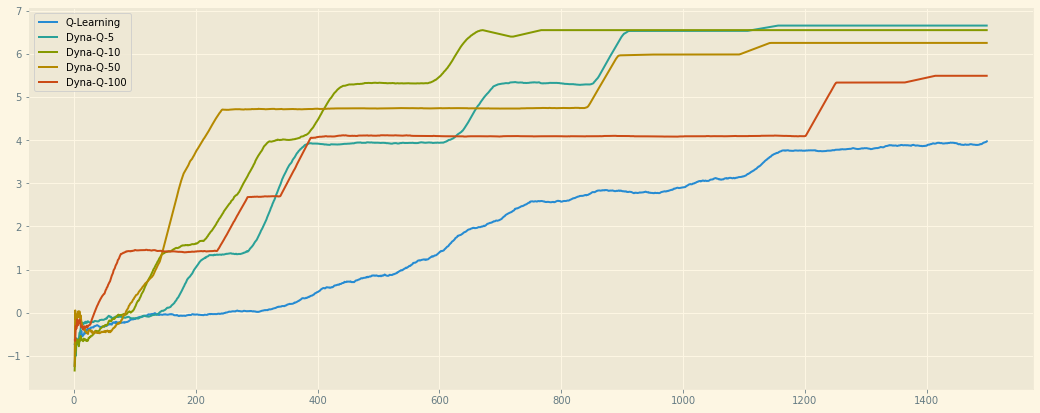

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots()
ax.plot([i+1 for i in range(MAX_ITERATIONS)], q_metrics["test_return"], label='Q-Learning')
ax.plot([i+1 for i in range(MAX_ITERATIONS)], dyna_metrics_5["test_return"], label='Dyna-Q-5')
ax.plot([i+1 for i in range(MAX_ITERATIONS)], dyna_metrics_10["test_return"], label='Dyna-Q-10')
ax.plot([i+1 for i in range(MAX_ITERATIONS)], dyna_metrics_50["test_reward"], label='Dyna-Q-50')
ax.plot([i+1 for i in range(MAX_ITERATIONS)], dyna_metrics_100["test_return"], label='Dyna-Q-100')

ax.legend()
fig.set_size_inches(18, 7)
plt.show()

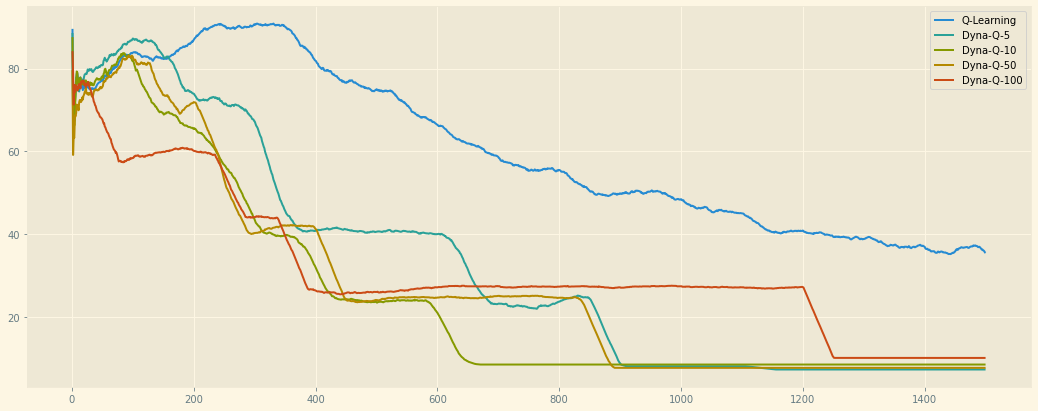

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots()
ax.plot([i+1 for i in range(MAX_ITERATIONS)], q_metrics["episode_len"], label='Q-Learning')
ax.plot([i+1 for i in range(MAX_ITERATIONS)], dyna_metrics_5["episode_len"], label='Dyna-Q-5')
ax.plot([i+1 for i in range(MAX_ITERATIONS)], dyna_metrics_10["episode_len"], label='Dyna-Q-10')
ax.plot([i+1 for i in range(MAX_ITERATIONS)], dyna_metrics_50["episode_len"], label='Dyna-Q-50')
ax.plot([i+1 for i in range(MAX_ITERATIONS)], dyna_metrics_100["episode_len"], label='Dyna-Q-100')

ax.legend()
fig.set_size_inches(18, 7)
plt.show()

## Exercício 02

Explique o comportamento das curvas nos gráficos gerados acima destacando por que o Dyna-Q consegue convergir mais rápido que o Q-Learning.

> Como fica explícito no primeiro gráfico (Número de iterações x Retorno médio), todos os agentes treinados com o algoritmo Dyna-Q possuem uma curva de crescimento mais rápida que o Q-learning puro. No entanto, ainda há alguns detalhes que devemos observar:
>- O Dyna Q-100 foi o mais rápido a atingir um retorno maior que 1, no entanto, ao longo das iterações, ele tende a ficar preso por mais tempo que os outros em platôs, ou seja, demora mais a crescer novamente.
>- O Dyna Q-50, ao fim de cerca de 200 iterações, foi o algoritmo que atingiu mais rapidamente o retorno de 5, mantendo-se assim por cerca de 100 iterações. No entanto, logo ele fica preso em platôs por muito tempo também.
>- Já o Dyna Q-10 foi o algoritmo com melhor curva de crescimento e que pouco tempo passava em platôs.
>- Em cerca de 1200 iterações, o Dyna Q-5 consegue superar todos e ter o melhor retorno médio.

> Vale a pena ressaltar que o Dyna Q consegue superar o Q learning rapidamente pelo fato de armazenar em memória um modelo do mundo e treinar N iterações nesse ambiente virtual, antes de iterar novamente 1 step sobre o mundo "real".

> Para o segundo gráfico (Número de iterações x Duração do episódio), vemos o mesmo comportamento do primeiro gráfico, ou seja, os algoritmos que performaram melhor, tiveram a mesma rapidez em encontrar caminhos menores e com maior retorno.